In [ ]:
from google.colab import drive
drive.mount("/content/drive/")


Mounted at /content/drive/


In [ ]:
import numpy as np
from datetime import datetime
%matplotlib inline 
import matplotlib.pyplot as plt
from numpy.polynomial import Polynomial



In [ ]:
# a bit of code to make loading CSV data easier

# headerTypes can be "I","F","S" or a datestring formater
# default is to treat everything as float

def getCSVFile(fName,goodLines=lambda a : True, headerLine="", splitChar=",",headerTypes=["F"]):
  i=0
  dataDict={}
  dataType={}
  if headerLine!="":
    LS=headerLine.split("\n")[0].split(splitChar)
    keyList=LS
    nCol=len(keyList)
    nTypes=len(headerTypes)
    for j in range(nCol):
      dataDict[keyList[j]]=[]
      dataType[keyList[j]]=headerTypes[j%nTypes]

  for line in open(fName):
    i=i+1
    if line=="\n":
      continue
    if line==headerLine:
      continue
    if goodLines(i):
      LS=line.split("\n")[0].split(splitChar)
      if headerLine=="":
        keyList=LS
        nCol=len(keyList)
        nTypes=len(headerTypes)
        headerLine=line
        for j in range(nCol):
          dataDict[keyList[j]]=[]
          dataType[keyList[j]]=headerTypes[j%nTypes]
        continue
      for j in range(nCol):
        if dataType[keyList[j]]=="S":
          dataDict[keyList[j]].append(LS[j]) 
        elif dataType[keyList[j]]=="F":
          try:
            dataDict[keyList[j]].append(float(LS[j]))
          except:
            dataDict[keyList[j]].append(float('nan'))
        elif dataType[keyList[j]]=="I":
          dataDict[keyList[j]].append(int(LS[j]))
        else:
          try:
            dataDict[keyList[j]].append(datetime.strptime(LS[j], dataType[keyList[j]]).timestamp())
          except:
            print(i,line,"||",LS[j])
    
  for k in keyList:
    dataDict[k]=np.array(dataDict[k])

  print(keyList)
  
  return dataDict

In [ ]:
def imageIndexFromTime(t):
  return int(np.interp(t,ImagedataDict['timeStamp']-dayStart,range(len(ImagedataDict['timeStamp']))))

def imuIndexFromTime(t):
  return int(np.interp(t,IMUdataDict['CurrTimestamp']-dayStart,range(len(IMUdataDict['CurrTimestamp']))))

def Indices_For_XrangeInc(Xrange,x):
  return [i for i in range(len(x)) if Xrange[0]<=x[i] and x[i]<=Xrange[1]]

In [ ]:
# these times are defined based on the data

# the start of the UTC day. Launch was about 2 pm UTC so start of day is a convenient "zero"
dayStart=datetime.strptime('2022-05-14 00:00:00.000000','%Y-%m-%d %H:%M:%S.%f').timestamp()

# IMU launch/landing time is determined later from looking at the data
IMUlaunch=datetime.strptime('2022-05-14 01:59:17.750000','%Y-%m-%d %H:%M:%S.%f').timestamp()
IMUlanding=20267+dayStart

# GPS launch/landing time is determined later by looking at the data
GPSlaunch=datetime.strptime('2022-05-14 01:59:15.000000','%Y-%m-%d %H:%M:%S.%f').timestamp()
GPSlanding=datetime.strptime('2022-05-14 05:37:42.500000','%Y-%m-%d %H:%M:%S.%f').timestamp()

# Image launch/landing times are based on the camera images and timestamps on image names

# offset between image and UTC based on timezone
imageTZoffset=5

# From Ken landing is "later than 003705 and at/earlier than 003746"
ImageLanding1=datetime.strptime('2022-05-14 00:37:05.000000','%Y-%m-%d %H:%M:%S.%f').timestamp()+3600*imageTZoffset
ImageLanding2=datetime.strptime('2022-05-14 00:37:46.000000','%Y-%m-%d %H:%M:%S.%f').timestamp()+3600*imageTZoffset



In [ ]:
print(IMUlaunch-GPSlaunch)
print(IMUlanding-GPSlanding)

2.75
4.5


In [ ]:
# get the data from the GPS log

Dpath="/content/drive/Shareddrives/NITELite/Data & Analysis/NITELite Flights/220513-FH135/data/OBC/"

GPSdataDict=getCSVFile(Dpath+'GPSLog.csv',
                       goodLines=lambda a : a==4 or (a>2989 and a<17270),
                       headerTypes=["%Y-%m-%d %H:%M:%S.%f","F","F","S","F","F","F","F","F","F","F","F","F"])

['CurrTimestamp', 'GPSLat', 'GPSLong', 'GPSTime', 'GPSAlt', 'GPSSpeed', 'GPSClimb', 'GPSHeading', 'LatErr', 'LonErr', 'SpeerErr', 'HeadErr', 'ClimbErr']


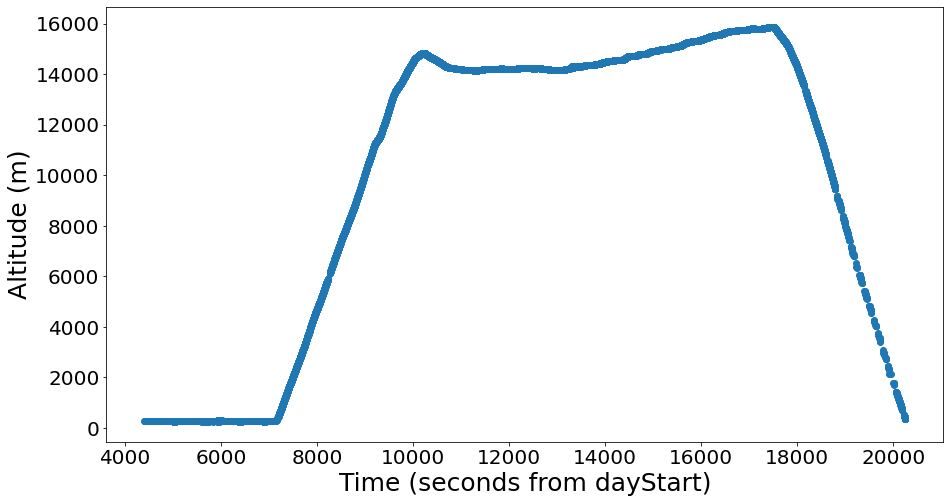

In [ ]:
# plot GPS data overall

fig = plt.figure(figsize=(15, 8))
ax = plt.subplot(111)

plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('axes' , labelsize=25)    # fontsize of the x and y labels

plt.xlabel('Time (seconds from dayStart)')
plt.ylabel('Altitude (m)')

ax.scatter(GPSdataDict['CurrTimestamp']-dayStart,GPSdataDict['GPSAlt'])

plt.show()

In [ ]:
# get a fit to the rising GPS data
I=Indices_For_XrangeInc((dayStart+7185,dayStart+7220),GPSdataDict['CurrTimestamp'])
GPSRising = Polynomial.fit(GPSdataDict['CurrTimestamp'][I], GPSdataDict['GPSAlt'][I], deg=1)

I=Indices_For_XrangeInc((dayStart+7100,dayStart+7140),GPSdataDict['CurrTimestamp'])
GPSFlat = Polynomial.fit(GPSdataDict['CurrTimestamp'][I], GPSdataDict['GPSAlt'][I], deg=0)

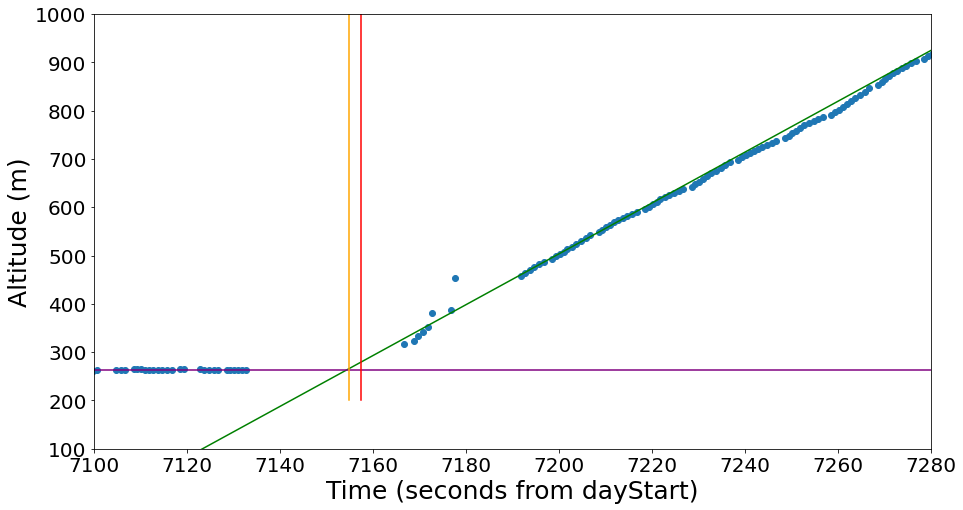

In [ ]:
# plot GPS launch data 

fig = plt.figure(figsize=(15, 8))
ax = plt.subplot(111)

plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('axes' , labelsize=25)    # fontsize of the x and y labels

plt.xlabel('Time (seconds from dayStart)')
plt.ylabel('Altitude (m)')

lowerT=7100; upperT=7280
ax.set_xlim(lowerT,upperT)
ax.set_ylim(100,1000)

ax.scatter(GPSdataDict['CurrTimestamp']-dayStart,GPSdataDict['GPSAlt'])

ax.plot([lowerT,upperT],[GPSRising(lowerT+dayStart),GPSRising(upperT+dayStart)],color="green")
ax.plot([lowerT,upperT],[GPSFlat(lowerT),GPSFlat(upperT)],color="purple")

ax.plot([IMUlaunch-dayStart,IMUlaunch-dayStart],[200,18000],color="red")
ax.plot([GPSlaunch-dayStart,GPSlaunch-dayStart],[200,18000],color="orange")

plt.show()

In [ ]:
# get a fit to the falling GPS data
I=Indices_For_XrangeInc((dayStart+20000,dayStart+20300),GPSdataDict['CurrTimestamp'])
GPSFalling = Polynomial.fit(GPSdataDict['CurrTimestamp'][I], GPSdataDict['GPSAlt'][I], deg=1)


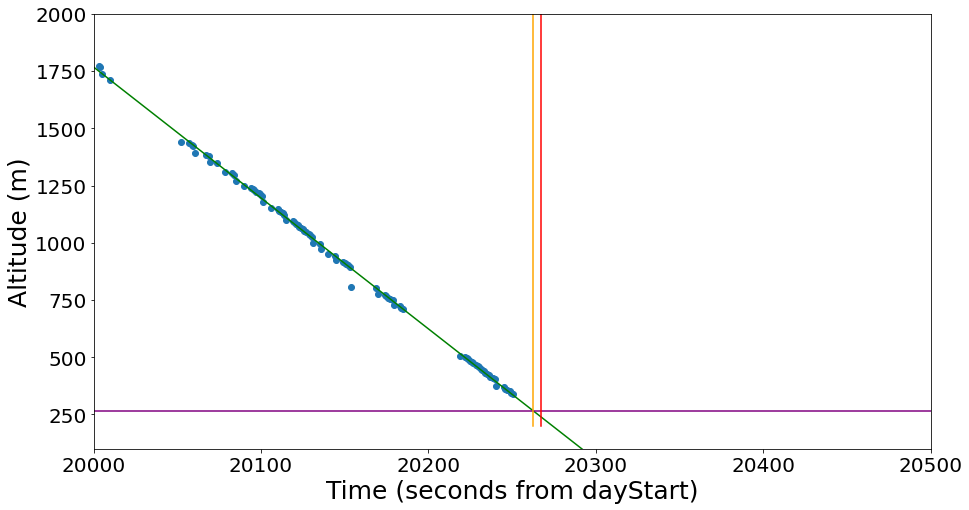

In [ ]:
# plot GPS landing data 

fig = plt.figure(figsize=(15, 8))
ax = plt.subplot(111)

plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('axes' , labelsize=25)    # fontsize of the x and y labels

plt.xlabel('Time (seconds from dayStart)')
plt.ylabel('Altitude (m)')

lowerT=20000; upperT=20500
ax.set_xlim(lowerT,upperT)
ax.set_ylim(100,2000)

ax.scatter(GPSdataDict['CurrTimestamp']-dayStart,GPSdataDict['GPSAlt'])

ax.plot([lowerT,upperT],[GPSFalling(lowerT+dayStart),GPSFalling(upperT+dayStart)],color="green")
ax.plot([lowerT,upperT],[GPSFlat(lowerT),GPSFlat(upperT)],color="purple")

ax.plot([GPSlanding-dayStart,GPSlanding-dayStart],[200,18000],color="orange")
ax.plot([IMUlanding-dayStart,IMUlanding-dayStart],[200,18000],color="red")



plt.show()




plt.show()

In [ ]:
GPSdataDict['GPSLat'][-1]

39.683740784

In [ ]:
GPSdataDict['GPSLong'][-1]

-86.442771646

In [ ]:
# get the data from the PresIMU log

Dpath="/content/drive/Shareddrives/NITELite/Data & Analysis/NITELite Flights/220513-FH135/data/OBC/"

IMUdataDict=getCSVFile(Dpath+'PresIMULog.csv',
                       goodLines=lambda a : a>81000 and a<1759000,
                       headerLine="CurrTimestamp,TempC,pressure,mAltitude,imuAccelX,imuAccelY,imuAccelZ,imuGyroX,imuGyroY,imuGyroZ,imuMagX,imuMagY,imuMagZ,imuRoll,imuPitch,imuYaw\n",
                       headerTypes=['%Y-%m-%d %H:%M:%S.%f']+["F"]*15)

['CurrTimestamp', 'TempC', 'pressure', 'mAltitude', 'imuAccelX', 'imuAccelY', 'imuAccelZ', 'imuGyroX', 'imuGyroY', 'imuGyroZ', 'imuMagX', 'imuMagY', 'imuMagZ', 'imuRoll', 'imuPitch', 'imuYaw']


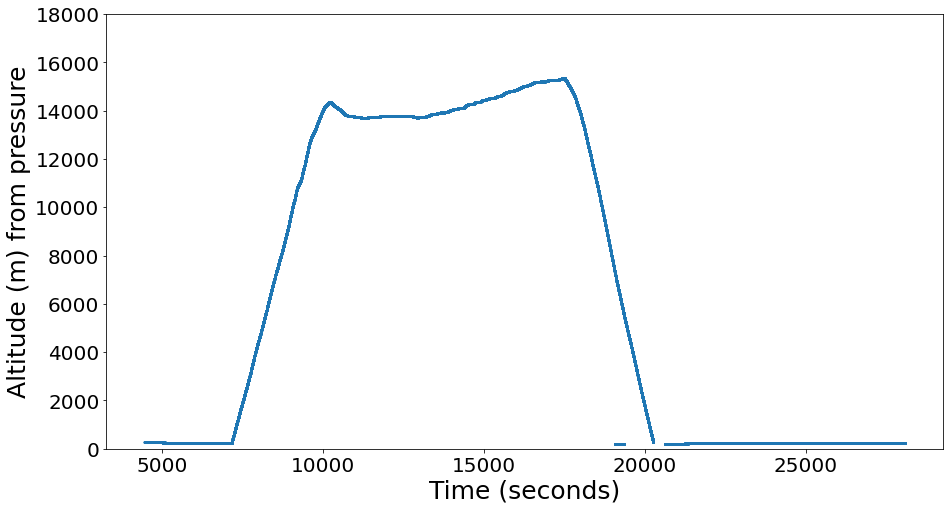

In [ ]:
# plot the overall IMU data

fig = plt.figure(figsize=(15, 8))
ax = plt.subplot(111)

plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('axes', labelsize=25)    # fontsize of the x and y labels

plt.xlabel('Time (seconds)')
plt.ylabel('Altitude (m) from pressure')

ax.set_ylim(0,18000)

ax.scatter(IMUdataDict['CurrTimestamp']-dayStart,IMUdataDict['mAltitude'],s=2)

plt.show()

In [ ]:
# get a fit to the rising IMU data
I=Indices_For_XrangeInc((dayStart+7185,dayStart+7280),IMUdataDict['CurrTimestamp'])
IMURising = Polynomial.fit(IMUdataDict['CurrTimestamp'][I], IMUdataDict['mAltitude'][I], deg=1)

I=Indices_For_XrangeInc((dayStart+7100,dayStart+7140),IMUdataDict['CurrTimestamp'])
IMUFlat = Polynomial.fit(IMUdataDict['CurrTimestamp'][I], IMUdataDict['mAltitude'][I], deg=0)

In [ ]:
IMUFlat(3)


251.72266307119332

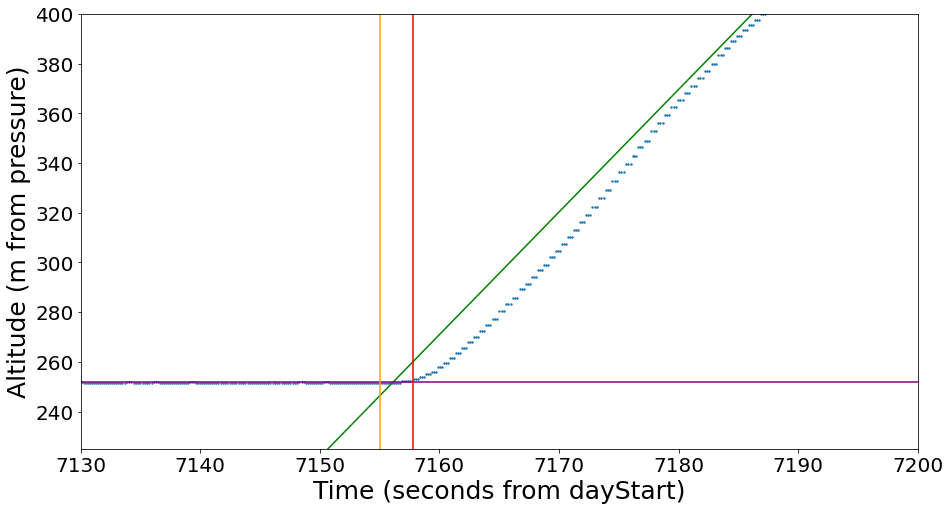

In [ ]:
fig = plt.figure(figsize=(15, 8))
ax = plt.subplot(111)

plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('axes', labelsize=25)    # fontsize of the x and y labels

plt.xlabel('Time (seconds from dayStart)')
plt.ylabel('Altitude (m from pressure)')

lowerT=7130; upperT=7200
ax.set_xlim(lowerT,upperT)
ax.set_ylim(225,400)


#ax.scatter(range(len(test))[0:100],test[0:100])
ax.scatter(IMUdataDict['CurrTimestamp']-dayStart,IMUdataDict['mAltitude'],s=2)


ax.plot([lowerT,upperT],[IMURising(lowerT+dayStart),IMURising(upperT+dayStart)],color="green")
ax.plot([lowerT,upperT],[IMUFlat(lowerT),IMUFlat(upperT)],color="purple")

ax.plot([IMUlaunch-dayStart,IMUlaunch-dayStart],[200,18000],color="red")
ax.plot([GPSlaunch-dayStart,GPSlaunch-dayStart],[200,18000],color="orange")


#ax.plot([20000,21000],[216,216],color="purple")

plt.show()

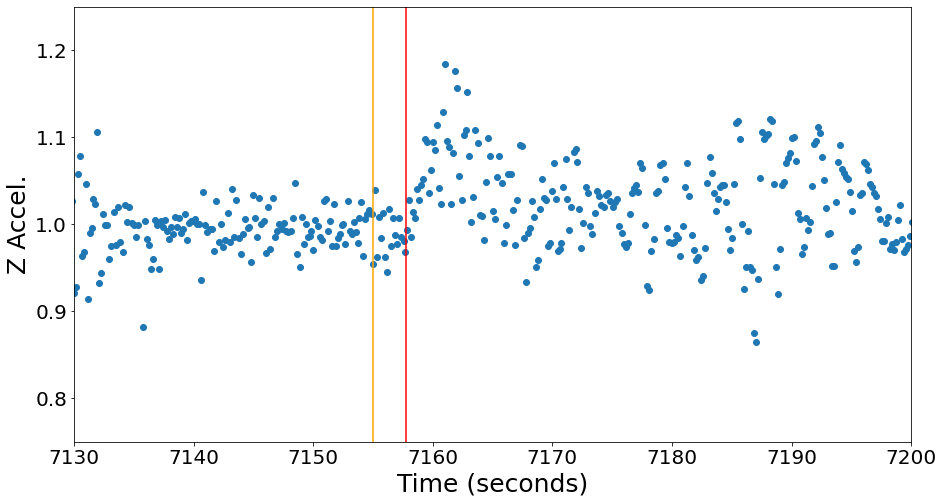

In [ ]:
fig = plt.figure(figsize=(15, 8))
ax = plt.subplot(111)

plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('axes', labelsize=25)    # fontsize of the x and y labels

plt.xlabel('Time (seconds)')
plt.ylabel('Z Accel.')

lowerT=7130; upperT=7200
ax.set_xlim(lowerT,upperT)
ax.set_ylim(0.75,1.25)

ax.scatter(IMUdataDict['CurrTimestamp']-dayStart,IMUdataDict['imuAccelZ'])

ax.plot([IMUlaunch-dayStart,IMUlaunch-dayStart],[0,2],color="red")
ax.plot([GPSlaunch-dayStart,GPSlaunch-dayStart],[0,2],color="orange")

plt.show()

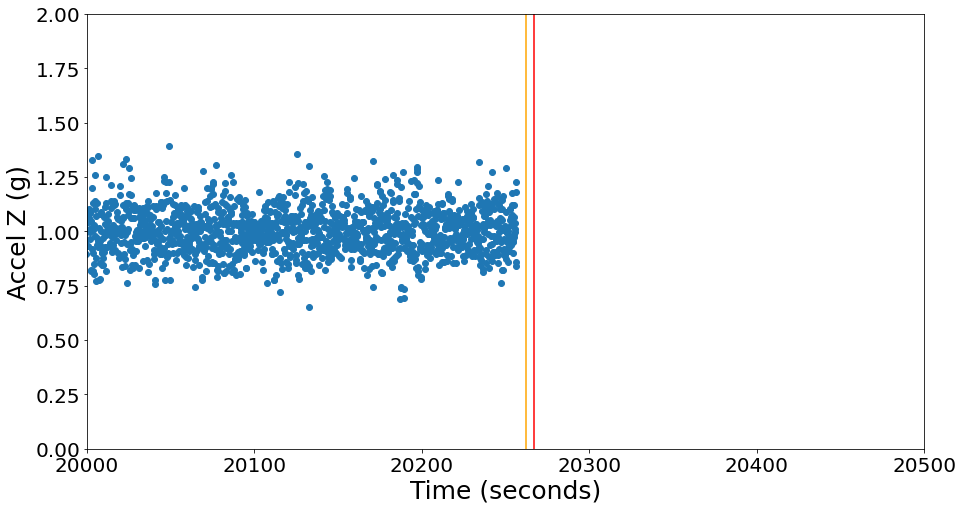

In [ ]:
fig = plt.figure(figsize=(15, 8))
ax = plt.subplot(111)

plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('axes', labelsize=25)    # fontsize of the x and y labels

plt.xlabel('Time (seconds)')
plt.ylabel('Accel Z (g)')

ax.set_xlim(20000,20500)
ax.set_ylim(0,2)

ax.scatter(IMUdataDict['CurrTimestamp']-dayStart,IMUdataDict['imuAccelZ'])

ax.plot([GPSlanding-dayStart,GPSlanding-dayStart],[0,2],color="orange")
ax.plot([IMUlanding-dayStart,IMUlanding-dayStart],[0,2],color="red")

plt.show()

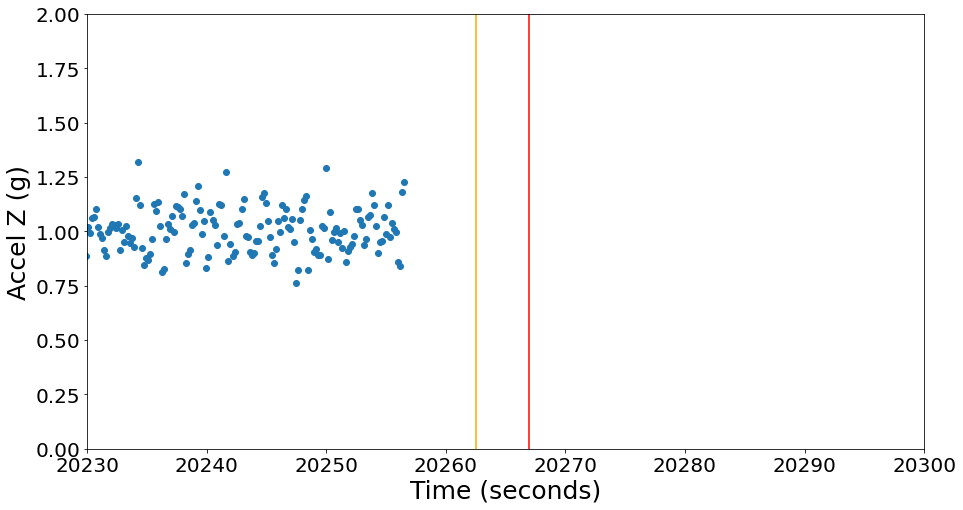

In [ ]:
fig = plt.figure(figsize=(15, 8))
ax = plt.subplot(111)

plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('axes', labelsize=25)    # fontsize of the x and y labels

plt.xlabel('Time (seconds)')
plt.ylabel('Accel Z (g)')

ax.set_xlim(20230,20300)
ax.set_ylim(0,2)

ax.scatter(IMUdataDict['CurrTimestamp']-dayStart,IMUdataDict['imuAccelZ'])

ax.plot([GPSlanding-dayStart,GPSlanding-dayStart],[0,2],color="orange")
ax.plot([IMUlanding-dayStart,IMUlanding-dayStart],[0,2],color="red")

plt.show()

In [ ]:
# get a fit to the falling IMU data
I=Indices_For_XrangeInc((dayStart+20200,dayStart+20255),IMUdataDict['CurrTimestamp'])
IMUFalling = Polynomial.fit(IMUdataDict['CurrTimestamp'][I], IMUdataDict['mAltitude'][I], deg=1)

I=Indices_For_XrangeInc((dayStart+20620,dayStart+20700),IMUdataDict['CurrTimestamp'])
IMUFlat = Polynomial.fit(IMUdataDict['CurrTimestamp'][I], IMUdataDict['mAltitude'][I], deg=0)

In [ ]:
IMUFlat(dayStart+20260)

216.62243778078147

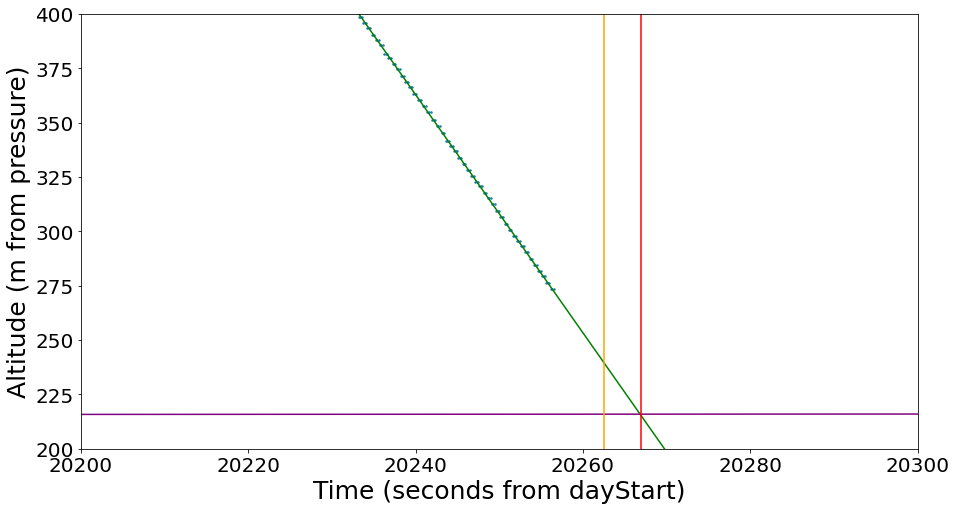

In [ ]:
fig = plt.figure(figsize=(15, 8))
ax = plt.subplot(111)

plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('axes', labelsize=25)    # fontsize of the x and y labels

plt.xlabel('Time (seconds from dayStart)')
plt.ylabel('Altitude (m from pressure)')

lowerT=20200; upperT=20300
ax.set_xlim(lowerT,upperT)
ax.set_ylim(200,400)


#ax.scatter(range(len(test))[0:100],test[0:100])
ax.scatter(IMUdataDict['CurrTimestamp']-dayStart,IMUdataDict['mAltitude'],s=2)


ax.plot([lowerT,upperT],[IMUFalling(lowerT+dayStart),IMUFalling(upperT+dayStart)],color="green")
ax.plot([lowerT,upperT],[IMUFlat(lowerT+dayStart),IMUFlat(upperT+dayStart)],color="purple")

ax.plot([IMUlanding-dayStart,IMUlanding-dayStart],[200,18000],color="red")
ax.plot([GPSlanding-dayStart,GPSlanding-dayStart],[200,18000],color="orange")



plt.show()


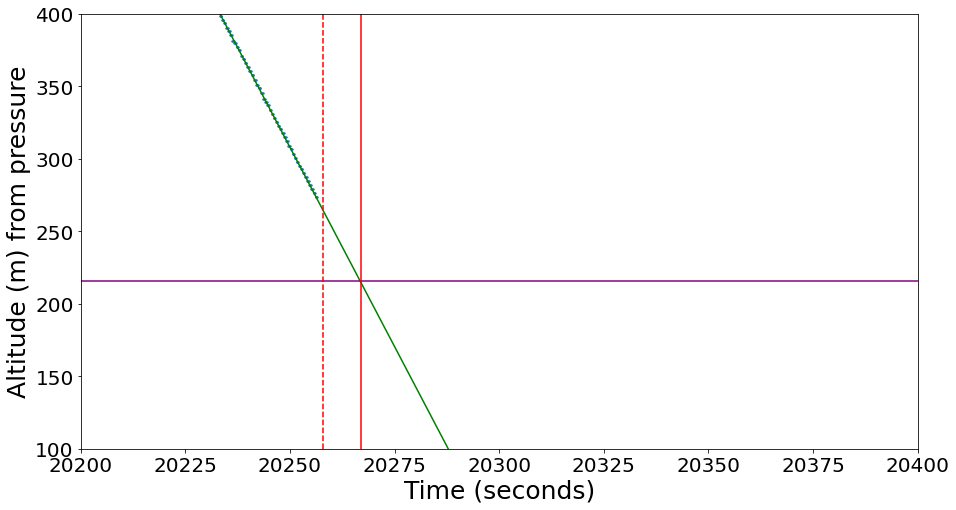

In [ ]:
fig = plt.figure(figsize=(15, 8))
ax = plt.subplot(111)

plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('axes', labelsize=25)    # fontsize of the x and y labels

plt.xlabel('Time (seconds)')
plt.ylabel('Altitude (m) from pressure')

ax.set_xlim(20200,20400)
ax.set_ylim(100,400)
#ax.scatter(range(len(test))[0:100],test[0:100])
ax.scatter(IMUdataDict['CurrTimestamp']-dayStart,IMUdataDict['mAltitude'],s=2)

ax.plot([IMUlaunch-dayStart,IMUlaunch-dayStart],[200,18000],color="red")



ax.plot([20000,20300],[1683,33],color="green")
ax.plot([20000,21000],[216,216],color="purple")
ax.plot([20267,20267],[100,400],color="red")
ax.plot([20258,20258],[100,400],color="red", linestyle="dashed")

plt.show()

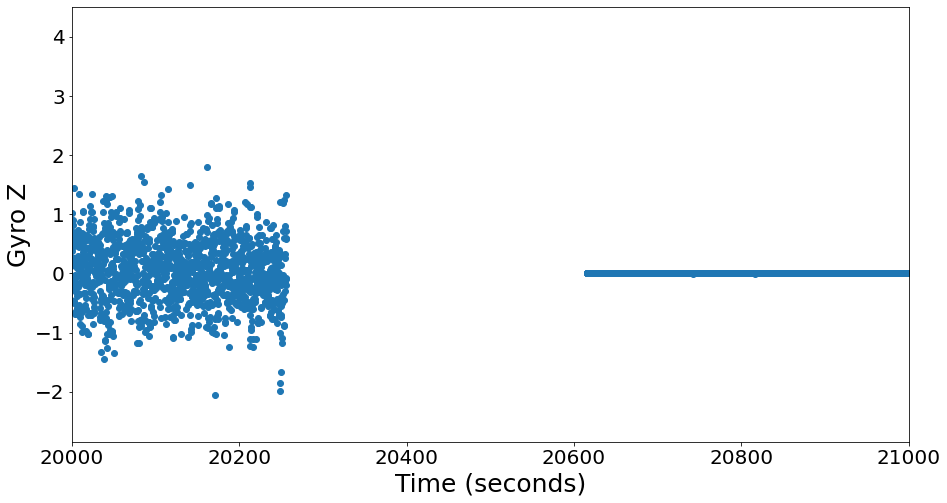

In [ ]:
fig = plt.figure(figsize=(15, 8))
ax = plt.subplot(111)

plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('axes', labelsize=25)    # fontsize of the x and y labels

plt.xlabel('Time (seconds)')
plt.ylabel('Gyro Z')

ax.set_xlim(20000,21000)
#ax.set_ylim(0,400)
#ax.scatter(range(len(test))[0:100],test[0:100])
ax.scatter(IMUdataDict['CurrTimestamp']-dayStart,IMUdataDict['imuGyroZ'])

#ax.plot([IMUlaunch-dayStart,IMUlaunch-dayStart],[200,18000],color="red")
plt.show()

In [ ]:
# get the image log

Dpath="/content/drive/Shareddrives/NITELite/Data & Analysis/NITELite Flights/220513-FH135/data/"

imageTZoffset=5
ImagedataDict={}
keyLine="odroid_time,obc_time,cameraNum,serial_number,exposure_time,idx,internal_temp,fileName"
LS=keyLine.split(',')
keyList=LS
print(len(keyList),keyList)
for j in range(len(keyList)):
  ImagedataDict[keyList[j]]=[]

i=0
for line in open(Dpath+'image.log'):
  LS=line.split(',')
  for j in range(len(keyList)):
    ImagedataDict[keyList[j]].append(LS[j]) 
  i=i+1

ImagedataDict['obc_time']=[s[0:5]+'05'+s[7:] for s in ImagedataDict['obc_time'][:]]

ImagedataDict['timeStamp']=np.array([3600*imageTZoffset+datetime.strptime(s[:16], ' %Y%m%d_%H%M%S').timestamp() for s in ImagedataDict['obc_time'][:]])
ImagedataDict['internal_temp']=np.array([float(s) for s in ImagedataDict['internal_temp']])

8 ['odroid_time', 'obc_time', 'cameraNum', 'serial_number', 'exposure_time', 'idx', 'internal_temp', 'fileName']


33786
[57. 61. 64. 66. 67. 62. 56. 49. 43. 34. 34. 32. 36. 35. 40. 45. 47. 48.
 43. 48. 45. 49. 46. 51. 57. 57. 58. 41. 29. 13. 15. 22. 36.]


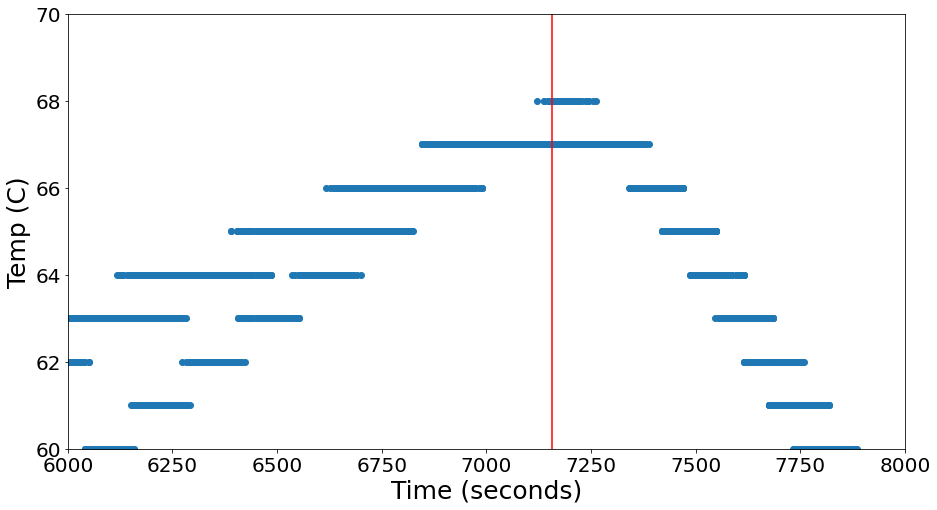

In [ ]:
print(len(ImagedataDict['internal_temp']))
print(ImagedataDict['internal_temp'][0:33000:1000])
    
fig = plt.figure(figsize=(15, 8))
ax = plt.subplot(111)

plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('axes', labelsize=25)    # fontsize of the x and y labels

plt.xlabel('Time (seconds)')
plt.ylabel('Temp (C)')

ax.set_xlim(6000,8000)
ax.set_ylim(60,70)
#ax.scatter(range(len(test))[0:100],test[0:100])
ax.scatter(ImagedataDict['timeStamp']-dayStart,ImagedataDict['internal_temp'])

ax.plot([IMUlaunch-dayStart,IMUlaunch-dayStart],[0,70],color="red")

plt.show()

33786
[57. 61. 64. 66. 67. 62. 56. 49. 43. 34. 34. 32. 36. 35. 40. 45. 47. 48.
 43. 48. 45. 49. 46. 51. 57. 57. 58. 41. 29. 13. 15. 22. 36.]


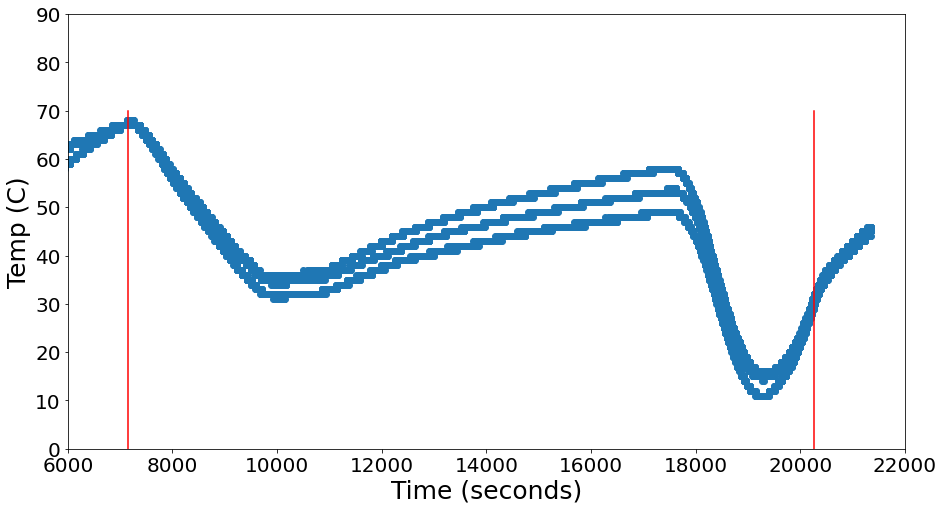

In [ ]:
print(len(ImagedataDict['internal_temp']))
print(ImagedataDict['internal_temp'][0:33000:1000])
    
fig = plt.figure(figsize=(15, 8))
ax = plt.subplot(111)

plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('axes', labelsize=25)    # fontsize of the x and y labels

plt.xlabel('Time (seconds)')
plt.ylabel('Temp (C)')

ax.set_xlim(6000,22000)
ax.set_ylim(0,90)
#ax.scatter(range(len(test))[0:100],test[0:100])
ax.scatter(ImagedataDict['timeStamp']-dayStart,ImagedataDict['internal_temp'])

ax.plot([IMUlaunch-dayStart,IMUlaunch-dayStart],[0,70],color="red")
ax.plot([IMUlanding-dayStart,IMUlanding-dayStart],[0,70],color="red")


plt.show()

In [ ]:
print(ImagedataDict['obc_time'][0:30])

[' 20220513_202739_536003', ' 20220513_202739_578439', ' 20220513_202740_620630', ' 20220513_202740_662081', ' 20220513_202740_703530', ' 20220513_202740_745696', ' 20220513_202740_787283', ' 20220513_202740_860185', ' 20220513_202740_931984', ' 20220513_202741_995770', ' 20220513_202741_1040331', ' 20220513_202741_1081878', ' 20220513_202741_1123564', ' 20220513_202741_1164817', ' 20220513_202741_1207325', ' 20220513_202741_1281220', ' 20220513_202742_1476398', ' 20220513_202743_1641917', ' 20220513_202748_1806949', ' 20220513_202748_1871786', ' 20220513_202748_1932218', ' 20220513_202748_1991504', ' 20220513_202748_2050507', ' 20220513_202749_2098751', ' 20220513_202749_2145534', ' 20220513_202749_2188246', ' 20220513_202749_2230671', ' 20220513_202749_2272908', ' 20220513_202749_2315813', ' 20220513_202750_2395801']


In [ ]:
print(ImagedataDict['obc_time'][-30:-1])

[' 20220514_005539_-1681419230', ' 20220514_005539_-1681368875', ' 20220514_005539_-1681300235', ' 20220514_005539_-1681226564', ' 20220514_005539_-1681156832', ' 20220514_005539_-1681096275', ' 20220514_005540_-1681048489', ' 20220514_005540_-1681007486', ' 20220514_005540_-1680966740', ' 20220514_005540_-1680925408', ' 20220514_005540_-1680737397', ' 20220514_005541_-1680577455', ' 20220514_005546_-1680385477', ' 20220514_005546_-1680322243', ' 20220514_005546_-1680278440', ' 20220514_005547_-1680237142', ' 20220514_005547_-1680196183', ' 20220514_005547_-1680154291', ' 20220514_005547_-1680113994', ' 20220514_005547_-1680043181', ' 20220514_005547_-1679974042', ' 20220514_005547_-1679912259', ' 20220514_005548_-1679838441', ' 20220514_005548_-1679778205', ' 20220514_005548_-1679725948', ' 20220514_005548_-1679685015', ' 20220514_005548_-1679643963', ' 20220514_005548_-1679602587', ' 20220514_005549_-1679431529']


In [ ]:
def imageIndexFromTime(t):
  return int(np.interp(t,ImagedataDict['timeStamp']-dayStart,range(len(ImagedataDict['timeStamp']))))

def imuIndexFromTime(t):
  return int(np.interp(t,IMUdataDict['CurrTimestamp']-dayStart,range(len(IMUdataDict['CurrTimestamp']))))


In [ ]:
print(ImagedataDict['fileName'][imageIndexFromTime(20265)])

 /home/pi/Pictures/23085688/20220414_003745_-1853906251_2_50_3.raw


In [ ]:
imuIndexFromTime(20265)

95790

In [ ]:
IMUdataDict.keys()

dict_keys(['CurrTimestamp', 'TempC', 'pressure', 'mAltitude', 'imuAccelX', 'imuAccelY', 'imuAccelZ', 'imuGyroX', 'imuGyroY', 'imuGyroZ', 'imuMagX', 'imuMagY', 'imuMagZ', 'imuRoll', 'imuPitch', 'imuYaw'])

In [ ]:
GPSdataDict.keys()

dict_keys(['CurrTimestamp', 'GPSLat', 'GPSLong', 'GPSTime', 'GPSAlt', 'GPSSpeed', 'GPSClimb', 'GPSHeading', 'LatErr', 'LonErr', 'SpeerErr', 'HeadErr', 'ClimbErr'])

In [ ]:
IMUdataDict.keys()

dict_keys(['CurrTimestamp', 'TempC', 'pressure', 'mAltitude', 'imuAccelX', 'imuAccelY', 'imuAccelZ', 'imuGyroX', 'imuGyroY', 'imuGyroZ', 'imuMagX', 'imuMagY', 'imuMagZ', 'imuRoll', 'imuPitch', 'imuYaw'])

In [ ]:
gyroZ_atImages=np.interp(ImagedataDict['timeStamp'],IMUdataDict['CurrTimestamp'],IMUdataDict['imuGyroZ'])
gpsLat_atImages=np.interp(ImagedataDict['timeStamp'],GPSdataDict['CurrTimestamp'],GPSdataDict['GPSLat'])
gpsLong_atImages=np.interp(ImagedataDict['timeStamp'],GPSdataDict['CurrTimestamp'],GPSdataDict['GPSLong'])
gpsAlt_atImages=np.interp(ImagedataDict['timeStamp'],GPSdataDict['CurrTimestamp'],GPSdataDict['GPSAlt'])
gpsSpeed_atImages=np.interp(ImagedataDict['timeStamp'],GPSdataDict['CurrTimestamp'],GPSdataDict['GPSSpeed'])


In [ ]:
import sys


In [ ]:
sys.stdout.write("%s"%3.96)

3.96

In [ ]:
Dpath="/content/drive/Shareddrives/NITELite/Data & Analysis/NITELite Flights/220513-FH135/data/"

with open(Dpath+"CollatedImageLog.csv","w") as outFile:

  for k in ImagedataDict.keys():
    outFile.write('%s, ' % (k))
  outFile.write("%s, %s, %s, %s, %s\n"%('imuGyroZ','GPSLat','GPSLong','GPSAlt','GPSSpeed'))

  for i in range(len(ImagedataDict['timeStamp'])):
    if True: #ImagedataDict['timeStamp'][i]-1652488000>6000 and ImagedataDict['timeStamp'][i]-1652488000<6200:
      for k in ImagedataDict.keys():
        outFile.write('%s, ' % (ImagedataDict[k][i]))
      outFile.write('%s, %s, %s, %s, %s\n' % (gyroZ_atImages[i],gpsLat_atImages[i],gpsLong_atImages[i],gpsAlt_atImages[i],gpsSpeed_atImages[i]))




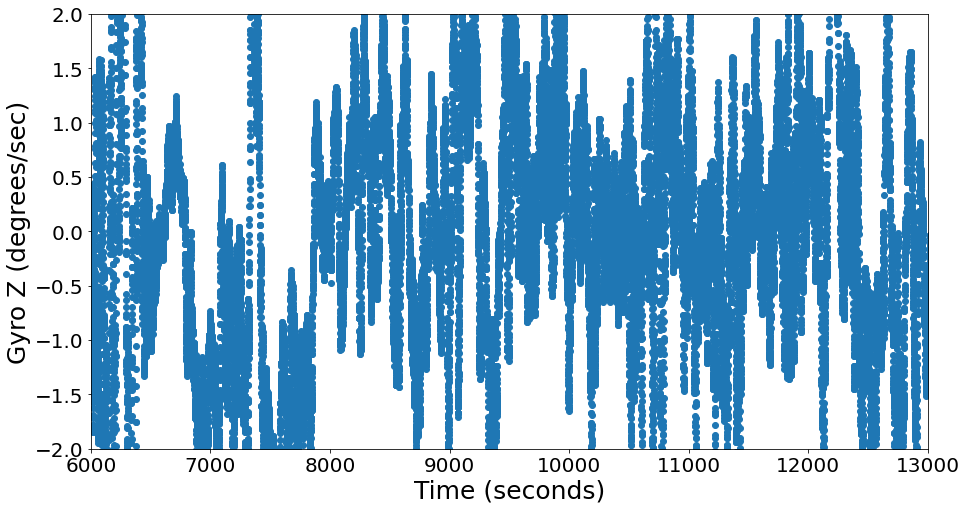

In [ ]:
fig = plt.figure(figsize=(15, 8))
ax = plt.subplot(111)

plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('axes', labelsize=25)    # fontsize of the x and y labels

plt.xlabel('Time (seconds)')
plt.ylabel('Gyro Z (degrees/sec)')

ax.set_xlim(6000,13000)
ax.set_ylim(-2,2)

#ax.scatter(dataDict['imuMagX'],dataDict['imuMagY'],s=1)
ax.scatter(IMUdataDict['CurrTimestamp']-IMUdataDict['CurrTimestamp'][0],180*IMUdataDict['imuGyroZ']/np.pi)
#ax.scatter(range(len(dataDict['CurrTimestamp'])),dataDict['CurrTimestamp']-dataDict['CurrTimestamp'][0])
#ax.scatter(range(len(dataDict['CurrTimestamp'])),dataDict['GPSAlt'])

#ax.plot([120,240],[13500,13500],color="red",linestyle="dashed")
#ax.plot([162,162],[2000,14500],color="green",linestyle="dashed")

plt.show()

In [ ]:
def getDeriv(x,t,s):
  N=len(x)

  kernel_size = s
  kernel = np.ones(kernel_size) / kernel_size
  return np.convolve(np.array([(x[1]-x[0])/(t[1]-t[0])]+[(x[i+1]-x[i-1])/(t[i+1]-t[i-1]) for i in range(1,N-1)]+[(x[-1]-x[-2])/(t[-1]-t[-2])])
, kernel, mode='same')

from scipy import integrate
  

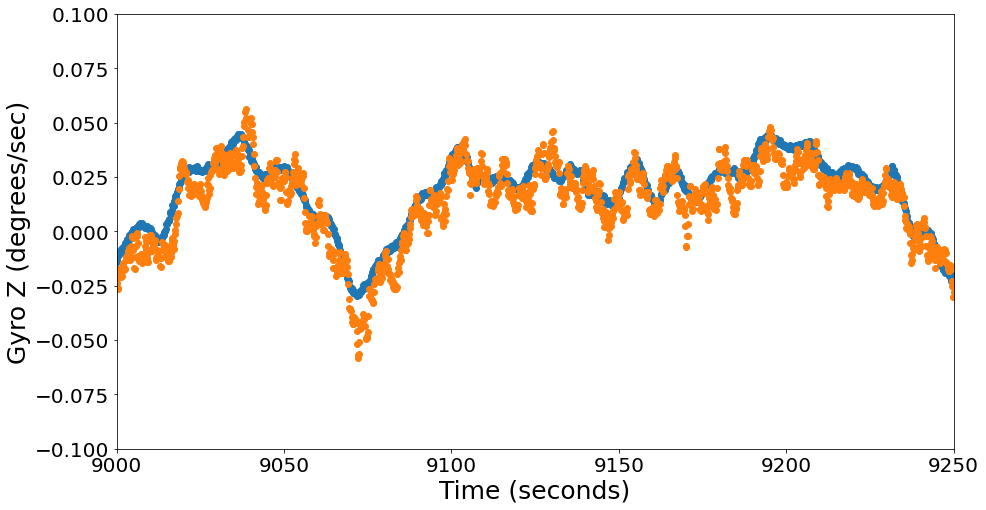

In [ ]:
fig = plt.figure(figsize=(15, 8))
ax = plt.subplot(111)

plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('axes', labelsize=25)    # fontsize of the x and y labels

plt.xlabel('Time (seconds)')
plt.ylabel('Gyro Z (degrees/sec)')

ax.set_xlim(9000,9250)
ax.set_ylim(-0.1,0.1)

ax.scatter(dataDict['CurrTimestamp']-dataDict['CurrTimestamp'][0],dataDict['imuGyroZ'])
ax.scatter(dataDict['CurrTimestamp']-dataDict['CurrTimestamp'][0],getDeriv(np.arctan2((dataDict['imuMagX']-58),dataDict['imuMagY']+32),dataDict['CurrTimestamp'],20))


plt.show()

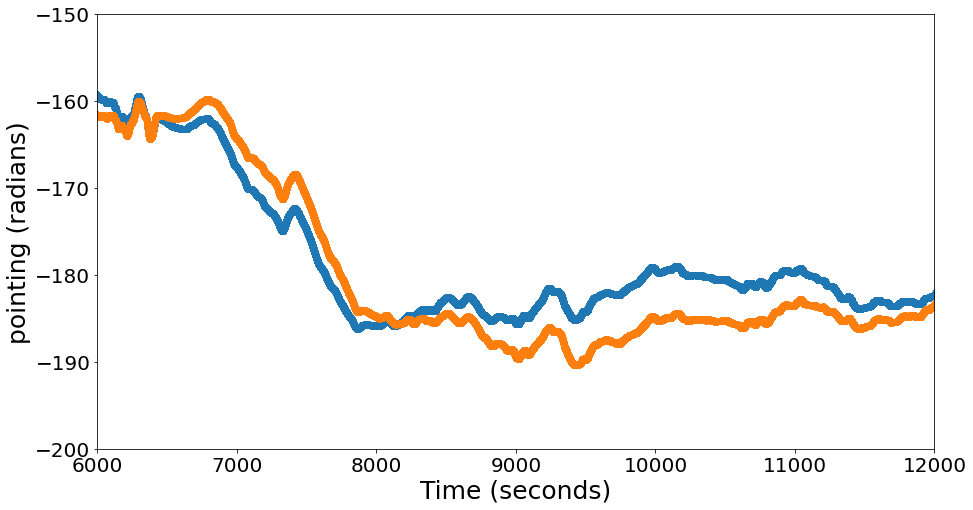

In [ ]:
theta_int = integrate.cumtrapz(dataDict['imuGyroZ']-0.0025, dataDict['CurrTimestamp']-dataDict['CurrTimestamp'][0], initial=0)

fig = plt.figure(figsize=(15, 8))
ax = plt.subplot(111)

plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('axes', labelsize=25)    # fontsize of the x and y labels

plt.xlabel('Time (seconds)')
plt.ylabel('pointing (radians)')

ax.set_xlim(6000,12000)
ax.set_ylim(-200,-150)

zp=np.interp(8000,dataDict['CurrTimestamp']-dataDict['CurrTimestamp'][0],np.arctan2((dataDict['imuMagX']-58),dataDict['imuMagY']+32))-np.interp(8000,dataDict['CurrTimestamp']-dataDict['CurrTimestamp'][0],theta_int)


#theta_int= (theta_int +zp + np.pi) % (2 * np.pi) - np.pi


ax.scatter(dataDict['CurrTimestamp']-dataDict['CurrTimestamp'][0],theta_int+20)
#ax.scatter(dataDict['CurrTimestamp']-dataDict['CurrTimestamp'][0],np.arctan2((dataDict['imuMagX']-58),dataDict['imuMagY']+32))
ax.scatter(dataDict['CurrTimestamp']-dataDict['CurrTimestamp'][0],np.unwrap(np.arctan2((dataDict['imuMagX']-58),dataDict['imuMagY']+32)))


plt.show()

In [ ]:
np.interp(8000,dataDict['CurrTimestamp']-dataDict['CurrTimestamp'][0],np.arctan2((dataDict['imuMagX']-58),dataDict['imuMagY']+32))
np.interp(8000,dataDict['CurrTimestamp']-dataDict['CurrTimestamp'][0],theta_int)

-2.583247001412641

In [ ]:
# get the data from the IMU log

Dpath="/content/drive/Shareddrives/NITELite/Data & Analysis/NITELite Flights/220513-FH135/data/OBC/"

start=datetime.strptime('2022-05-14 01:00:00.000000','%Y-%m-%d %H:%M:%S.%f').timestamp()
end=datetime.strptime('2022-05-14 10:00:00.000000','%Y-%m-%d %H:%M:%S.%f').timestamp()
headerLine=""
IMUdataDict={}
i=0
for line in open(Dpath+'PresIMULog.csv'):
  LS=line.split(',')

  if line==headerLine:
    continue
  if i==0:
    headerLine=line
    keyList=LS
    print(len(keyList),keyList)
    CTSIndex=keyList.index('CurrTimestamp')
    print(CTSIndex)
    for j in range(len(keyList)):
      IMUdataDict[keyList[j]]=[]
    i=i+1
    continue

  if len(LS)==len(keyList):
    if "." in LS[CTSIndex]:
      T=datetime.strptime(LS[CTSIndex],'%Y-%m-%d %H:%M:%S.%f').timestamp()
    else:
      T=datetime.strptime(LS[CTSIndex],'%Y-%m-%d %H:%M:%S').timestamp()
      print(i,line)

    if T>start and T<end and len(LS)==len(keyList):
      for j in range(len(keyList)):
        IMUdataDict[keyList[j]].append(LS[j]) 
      IMUdataDict[keyList[CTSIndex]][-1]=T
    i=i+1

#dataDict['CurrTimestamp']=[datetime.strptime(s, '%Y-%m-%d %H:%M:%S.%f').timestamp() for s in dataDict['CurrTimestamp'][:]]

for k in keyList:
    IMUdataDict[k]=np.array([float(s) for s in IMUdataDict[k]])

16 ['CurrTimestamp', 'TempC', 'pressure', 'mAltitude', 'imuAccelX', 'imuAccelY', 'imuAccelZ', 'imuGyroX', 'imuGyroY', 'imuGyroZ', 'imuMagX', 'imuMagY', 'imuMagZ', 'imuRoll', 'imuPitch', 'imuYaw\n']
0
